In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

# Graph Metrics

In [2]:
import pandas as pd
import utils as ut
import numpy as np
from sgnn.model import GCN
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import pandas as pd
from graph_metrics import GraphMetrics
import numpy as np

df = pd.read_csv('/Users/rodrigo/Documents/data/Ayahuasca/data/subacute_pre_processed/corr_matrices_gordon.csv')#.drop(columns='Unnamed: 0')
HRS = pd.read_csv('/Users/rodrigo/Documents/data/Ayahuasca/data/ayahuasca_acute_preacute/Ayahuasca_HRS.csv')
communities = pd.read_excel('/Users/rodrigo/Documents/data/INPD/parcels.xlsx', na_values=['None'])
communities = communities.where(pd.notnull(communities), str(None)) # Replace with your file path
communities['Community'] = communities.Community.astype(str)

N = 333


condition = (
    ((df['Group'] == 'J') & (df['Subject'].isin([7, 9, 18]))) |     # Examinate subject 18
    ((df['Group'] == 'O') & (df['Subject'].isin([1, 7])))
)

# Inverting the condition to keep rows that do NOT match the condition
df = df[~condition]

import pandas as pd
import numpy as np

# Initialize an empty DataFrame to store all results
all_metrics_df = pd.DataFrame()

# Example loop over groups, time points, and subjects
for g in ['Placebo', 'Ayahuasca']:
    for i in ['before', 'after']:
        aux = df[(df.Time == i) & (df.Group == g)]

        for subject in aux['Subject'].unique():
            subject_data = aux[aux['Subject'] == subject]
            X_fmri = subject_data.select_dtypes(include=float).iloc[:,:-6]

            if X_fmri.empty:
                continue

            adj_matrix = ut.reconstruct_symmetric_matrix(333, X_fmri, 1)

            # Initialize the GraphMetrics class with the adjacency matrix
            metrics = GraphMetrics(adj_matrix)

            # Calculate community-based metrics
            community_metrics = metrics.calculate_community_metrics(communities)

            # Convert the community_metrics dictionary into a DataFrame for easier storing
            metrics_df = pd.DataFrame(community_metrics).T.reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')
            metrics_df.rename(columns={'index': 'Community'}, inplace=True)

            # Add additional columns for Group, Time, and Subject
            metrics_df['Group'] = g
            metrics_df['Time'] = i
            metrics_df['Subject'] = subject

            # Append the current subject's metrics to the cumulative DataFrame
            all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

# Display the final DataFrame
print(all_metrics_df)

all_metrics_df['Change'] = all_metrics_df.groupby(['Subject', 'Group','Metric','Community'])['Value'].diff()
#all_metrics_df = all_metrics_df.dropna().drop(columns='Time')


/Users/rodrigo/miniconda3/envs/ising_gnn/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


                  Community          Metric      Value      Group    Time  \
0                   Default     segregation   1.726960    Placebo  before   
1                    SMhand     segregation   1.861270    Placebo  before   
2                   SMmouth     segregation   2.179852    Placebo  before   
3                    Visual     segregation   1.855979    Placebo  before   
4            FrontoParietal     segregation   2.121611    Placebo  before   
...                     ...             ...        ...        ...     ...   
5845  RetrosplenialTemporal  average_degree   8.155991  Ayahuasca   after   
5846           CinguloOperc  average_degree  29.156189  Ayahuasca   after   
5847            VentralAttn  average_degree  17.707561  Ayahuasca   after   
5848               Salience  average_degree   4.239507  Ayahuasca   after   
5849             DorsalAttn  average_degree  24.276296  Ayahuasca   after   

      Subject  
0          10  
1          10  
2          10  
3          

In [3]:
all_metrics_df

,Community,Metric,Value,Group,Time,Subject,Change
0,Default,segregation,1.726960,Placebo,before,10,NaN
1,SMhand,segregation,1.861270,Placebo,before,10,NaN
2,SMmouth,segregation,2.179852,Placebo,before,10,NaN
3,Visual,segregation,1.855979,Placebo,before,10,NaN
4,FrontoParietal,segregation,2.121611,Placebo,before,10,NaN
...,...,...,...,...,...,...,...
5845,RetrosplenialTemporal,average_degree,8.155991,Ayahuasca,after,8,0.502608
5846,CinguloOperc,average_degree,29.156189,Ayahuasca,after,8,-1.046535
5847,VentralAttn,average_degree,17.707561,Ayahuasca,after,8,0.061040
5848,Salience,average_degree,4.239507,Ayahuasca,after,8,0.064015


<Axes: xlabel='Community', ylabel='Change'>

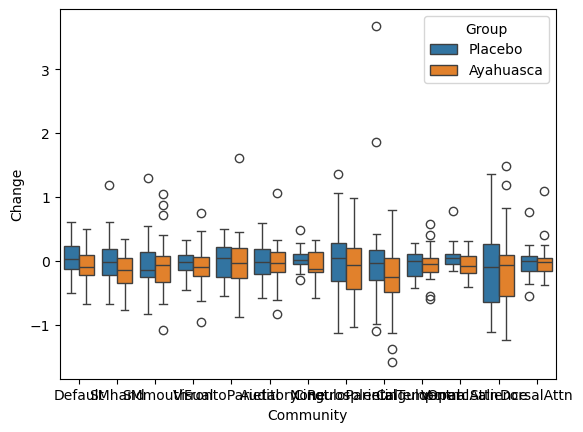

In [4]:
sns.boxplot(data=all_metrics_df[all_metrics_df.Metric == 'segregation'], hue='Group', y='Change', x='Community')

In [5]:
# grouped_metrics_df = all_metrics_df.groupby(['Group', 'Time', 'Community', 'Metric']).agg(
#     Mean_Value=('Value', 'mean'),
#     Std_Value=('Value', 'std')
# ).reset_index()

# # Assuming grouped_metrics_df has been created from the previous steps
# # grouped_metrics_df should have columns: Group, Time, Community, Metric, Mean_Value, Std_Value

# # Iterate over each unique community to create a separate plot

# grouped_metrics_df = grouped_metrics_df[grouped_metrics_df.Time == 'after']

# for community in grouped_metrics_df['Community'].unique():
#     community_data = grouped_metrics_df[grouped_metrics_df['Community'] == community]
    
#     # Create the plot
#     plt.figure(figsize=(10, 6))
#     ax = sns.barplot(data=community_data, x='Group', y='Mean_Value', hue='Metric', ci=None)

#     # Add error bars for standard deviation
#     for index, row in community_data.iterrows():
#         # Find the x position of the bar by getting the correct position in the plot
#         bar_group_position = np.where(ax.get_xticks() == np.where(grouped_metrics_df['Group'].unique() == row['Group'])[0][0])[0][0]
#         bar_width = 0.8 / len(grouped_metrics_df['Metric'].unique())  # Width per hue bar
        
#         # Offset position depending on the metric (hue)
#         hue_offset = list(grouped_metrics_df['Metric'].unique()).index(row['Metric'])
#         x_position = bar_group_position - 0.4 + hue_offset * bar_width + bar_width / 2
        
#         ax.errorbar(x=x_position, y=row['Mean_Value'], yerr=row['Std_Value'], fmt='none', c='black', capsize=5)

#     # Customize the plot
#     plt.title(f'Graph Metrics for Community: {community}')
#     plt.xlabel('Group')
#     plt.ylabel('Mean Metric Value')
#     plt.xticks(rotation=45)
#     plt.legend(title='Metric')
#     plt.tight_layout()
    
#     # Show the plot
#     plt.show()

In [6]:
all_metrics_df

,Community,Metric,Value,Group,Time,Subject,Change
0,Default,segregation,1.726960,Placebo,before,10,NaN
1,SMhand,segregation,1.861270,Placebo,before,10,NaN
2,SMmouth,segregation,2.179852,Placebo,before,10,NaN
3,Visual,segregation,1.855979,Placebo,before,10,NaN
4,FrontoParietal,segregation,2.121611,Placebo,before,10,NaN
...,...,...,...,...,...,...,...
5845,RetrosplenialTemporal,average_degree,8.155991,Ayahuasca,after,8,0.502608
5846,CinguloOperc,average_degree,29.156189,Ayahuasca,after,8,-1.046535
5847,VentralAttn,average_degree,17.707561,Ayahuasca,after,8,0.061040
5848,Salience,average_degree,4.239507,Ayahuasca,after,8,0.064015


In [14]:
results_df

,Community,Metric,t_statistic,p_value,p_value_corrected
0,Default,segregation,1.234437,0.223744,0.649306
1,Default,average_clustering,0.045512,0.963910,0.963910
2,Default,average_betweenness_centrality,0.869163,0.389583,0.649306
3,Default,average_path_lenght,-0.917453,0.364023,0.649306
4,Default,average_degree,0.075260,0.940357,0.963910
...,...,...,...,...,...
60,DorsalAttn,segregation,-0.137065,0.891619,0.891619
61,DorsalAttn,average_clustering,-1.249452,0.218258,0.382064
62,DorsalAttn,average_betweenness_centrality,1.036743,0.305651,0.382064
63,DorsalAttn,average_path_lenght,-1.193469,0.239229,0.382064


In [17]:
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu, ttest_rel
from statsmodels.stats.multitest import multipletests

# Filter the DataFrame for the 'after' time point
all_metrics_aux = all_metrics_df[all_metrics_df['Time'] == 'after']

# Initialize an empty list to store results
results = []

# Loop through each community
for community in all_metrics_df['Community'].unique():
    community_results = []
    
    # Loop through each metric within the community
    for metric in all_metrics_aux['Metric'].unique():
        # Extract data for each group
        group_O = all_metrics_aux[(all_metrics_aux['Community'] == community) & 
                           (all_metrics_aux['Metric'] == metric) & 
                           (all_metrics_aux['Group'] == 'Placebo')]['Change'].values
        group_J = all_metrics_aux[(all_metrics_aux['Community'] == community) & 
                           (all_metrics_aux['Metric'] == metric) & 
                           (all_metrics_aux['Group'] == 'Ayahuasca')]['Change'].values
        
        # Check if we have enough data to perform the test
        if len(group_O) > 1 and len(group_J) > 1:
            # Perform t-test (assuming normal distribution)
            t_stat, p_val = ttest_rel(group_O, group_J)
            # Alternatively, perform Mann-Whitney U test for non-normal distributions:
            # u_stat, p_val = mannwhitneyu(group_O, group_J)
            
            # Store the results
            community_results.append({
                'Community': community,
                'Metric': metric,
                't_statistic': t_stat,
                'p_value': p_val
            })
    
    # Convert community results to a DataFrame
    community_df = pd.DataFrame(community_results)
    
    # Apply multiple comparisons correction within this community
    community_df['p_value_corrected'] = multipletests(community_df['p_value'], method='fdr_bh')[1]
    
    # Add the community's corrected results to the overall results
    results.append(community_df)

# Combine all community results into a single DataFrame
results_df = pd.concat(results, ignore_index=True)

# Display the results with corrected p-values
#print("Results with Multiple Comparisons Correction:")
#print(results_df)

# Filter and display significant results after correction (e.g., corrected p < 0.05)
significant_corrected_results = results_df[results_df['p_value'] < 0.05]

print('Significat results')
results_df[results_df['p_value'] < 0.05]

Significat results


,Community,Metric,t_statistic,p_value,p_value_corrected


# Global metrics

In [18]:
import sys
import os

sys.path.append(os.path.abspath(".."))

import pandas as pd
import utils as ut
import numpy as np
from sgnn.model import GCN
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import pandas as pd
from graph_metrics import GraphMetrics
import numpy as np

df = pd.read_csv('/Users/rodrigo/Documents/data/Ayahuasca/data/subacute_pre_processed/corr_matrices_gordon.csv')#.drop(columns='Unnamed: 0')
HRS = pd.read_csv('/Users/rodrigo/Documents/data/Ayahuasca/data/ayahuasca_acute_preacute/Ayahuasca_HRS.csv')

N = 333


condition = (
    ((df['Group'] == 'Ayahuasca') & (df['Subject'].isin([7, 9, 18]))) |     # Examinate subject 18
    ((df['Group'] == 'Placebo') & (df['Subject'].isin([1, 7])))
)

# Inverting the condition to keep rows that do NOT match the condition
df = df[~condition]

import pandas as pd
import numpy as np

# Initialize an empty DataFrame to store all results
all_metrics_df = pd.DataFrame()

# Example loop over groups, time points, and subjects
for g in ['Placebo', 'Ayahuasca']:
    for i in ['before', 'after']:
        aux = df[(df.Time == i) & (df.Group == g)]

        for subject in aux['Subject'].unique():
            subject_data = aux[aux['Subject'] == subject]
            X_fmri = subject_data.select_dtypes(include=float).iloc[:,:-6]

            if X_fmri.empty:
                continue

            adj_matrix = ut.reconstruct_symmetric_matrix(333, X_fmri, 1)

            # Initialize the GraphMetrics class with the adjacency matrix
            metrics = GraphMetrics(adj_matrix)

            # Calculate community-based metrics
            metrics_dict = metrics.calculate_global_metrics()

            # Convert the dictionary to a DataFrame
            metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index', columns=['Value'])

            # Reset the index to make it more readable
            metrics_df = metrics_df.reset_index()

            # Rename the columns
            metrics_df.columns = ['Metric', 'Value']

            # Add additional columns for Group, Time, and Subject
            metrics_df['Group'] = g
            metrics_df['Time'] = i
            metrics_df['Subject'] = subject

            # Append the current subject's metrics to the cumulative DataFrame
            all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

# Display the final DataFrame
print(all_metrics_df)
all_metrics_df['Change'] = all_metrics_df.groupby(['Subject', 'Group','Metric'])['Value'].diff()
#all_metrics_df = all_metrics_df.dropna().drop(columns='Time')


                             Metric       Value      Group    Time  Subject
0                average_clustering    0.269293    Placebo  before       10
1    average_betweenness_centrality    0.013211    Placebo  before       10
2                  spectral_entropy    5.736355    Placebo  before       10
3               average_path_length    0.019757    Placebo  before       10
4                    average_degree   93.339759    Placebo  before       10
..                              ...         ...        ...     ...      ...
435              average_clustering    0.643963  Ayahuasca   after        8
436  average_betweenness_centrality    0.006337  Ayahuasca   after        8
437                spectral_entropy    5.794549  Ayahuasca   after        8
438             average_path_length    0.335463  Ayahuasca   after        8
439                  average_degree  219.344843  Ayahuasca   after        8

[440 rows x 5 columns]


In [19]:
grouped_metrics_df = all_metrics_df.groupby(['Group', 'Time', 'Metric']).agg(
    Mean_Value=('Value', 'mean'),
    Std_Value=('Value', 'std')
).reset_index()

In [22]:
metrics_dict

{'average_clustering': 0.6439628008555558,
 'average_betweenness_centrality': 0.006336770286830346,
 'spectral_entropy': 5.794549322827199,
 'average_path_length': 0.3354628872381739,
 'average_degree': 219.3448426771256}

In [23]:
results_df

,Metric,t_statistic,p_value,p_value_corrected
0,average_clustering,-2.486022,0.016981,0.036097
1,average_betweenness_centrality,2.196863,0.033601,0.042001
2,spectral_entropy,-1.119407,0.269327,0.269327
3,average_path_length,-2.385208,0.021658,0.036097
4,average_degree,-2.405197,0.020647,0.036097


In [21]:
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Filter the DataFrame for the 'after' time point
after_df = all_metrics_df[all_metrics_df['Time'] == 'after']

import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu

# Assuming grouped_metrics_df has been created from the previous steps
# grouped_metrics_df should have columns: Group, Time, Community, Metric, Mean_Value, Std_Value

# Filter the DataFrame for the 'after' time point

# Initialize an empty list to store results
results = []

# Loop through each metric and community
for metric in all_metrics_df['Metric'].unique():
    # Extract data for each group
    group_O = all_metrics_df[ 
                        (all_metrics_df['Metric'] == metric) & 
                        (all_metrics_df['Group'] == 'Placebo')
                        & (all_metrics_df['Time'] == 'after')]['Value'].values
    group_J = all_metrics_df[ 
                        (all_metrics_df['Metric'] == metric) & 
                        (all_metrics_df['Group'] == 'Ayahuasca')
                        & (all_metrics_df['Time'] == 'after')]['Value'].values
    
    # Check if we have enough data to perform the test
    if len(group_O) > 1 and len(group_J) > 1:
        # Perform t-test (assuming normal distribution)
        t_stat, p_val = ttest_ind(group_O, group_J)
        # Alternatively, perform Mann-Whitney U test for non-normal distributions:
        # u_stat, p_val = mannwhitneyu(group_O, group_J)
        
        # Store the results
        results.append({
            'Metric': metric,
            't_statistic': t_stat,
            'p_value': p_val
        })


# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Apply multiple comparisons correction using the Benjamini-Hochberg method (FDR)
results_df['p_value_corrected'] = multipletests(results_df['p_value'], method='fdr_bh')[1]

# Optionally, you could use Bonferroni correction instead:
# results_df['p_value_corrected'] = multipletests(results_df['p_value'], method='bonferroni')[1]

# Display the results with corrected p-values
print("Significant Results")
print(results_df[results_df['p_value'] < 0.05])

# If you want to filter significant results after correction (e.g., corrected p < 0.05)
significant_corrected_results = results_df[results_df['p_value_corrected'] < 0.05]
print("Significant Results after Correction (corrected p < 0.05):")
print(significant_corrected_results)

Significant Results
                           Metric  t_statistic   p_value  p_value_corrected
0              average_clustering    -2.486022  0.016981           0.036097
1  average_betweenness_centrality     2.196863  0.033601           0.042001
3             average_path_length    -2.385208  0.021658           0.036097
4                  average_degree    -2.405197  0.020647           0.036097
Significant Results after Correction (corrected p < 0.05):
                           Metric  t_statistic   p_value  p_value_corrected
0              average_clustering    -2.486022  0.016981           0.036097
1  average_betweenness_centrality     2.196863  0.033601           0.042001
3             average_path_length    -2.385208  0.021658           0.036097
4                  average_degree    -2.405197  0.020647           0.036097


# Temperature

/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_13197/1002866019.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['STD'] = X_fmri.std(axis=1)
/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_13197/1002866019.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['MEAN'] = X_fmri.mean(axis=1)
/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_13197/1002866019.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which us

Change TtestResult(statistic=-2.1879517079045474, pvalue=0.034288458644336876, df=42.0)


/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_13197/1002866019.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['TEMP'] = y_pred_aux_age
/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_13197/1002866019.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.boxplot(result, x='Group', y='Change',palette=colors)
/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_13197/1002866019.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(['Placebo', 'Ayahuasca'],  fontsize=1

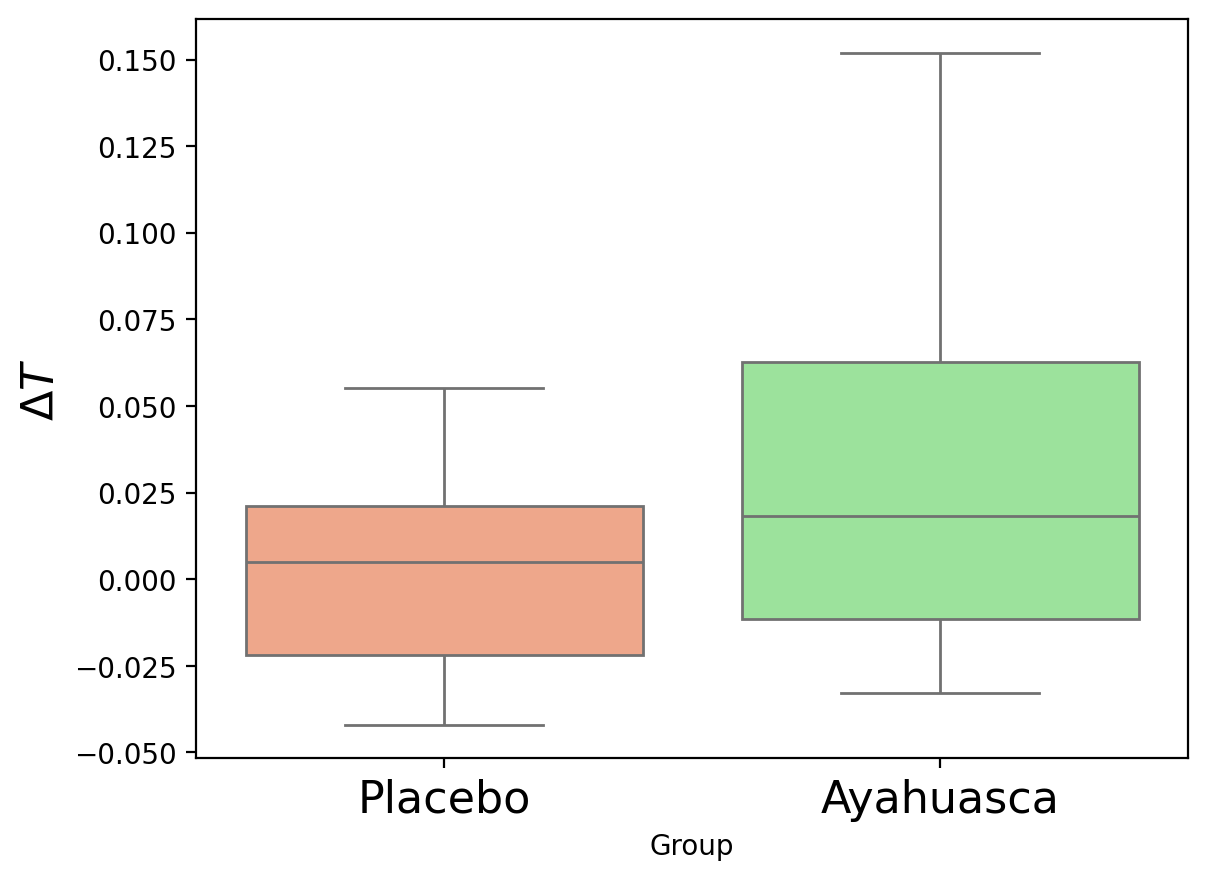

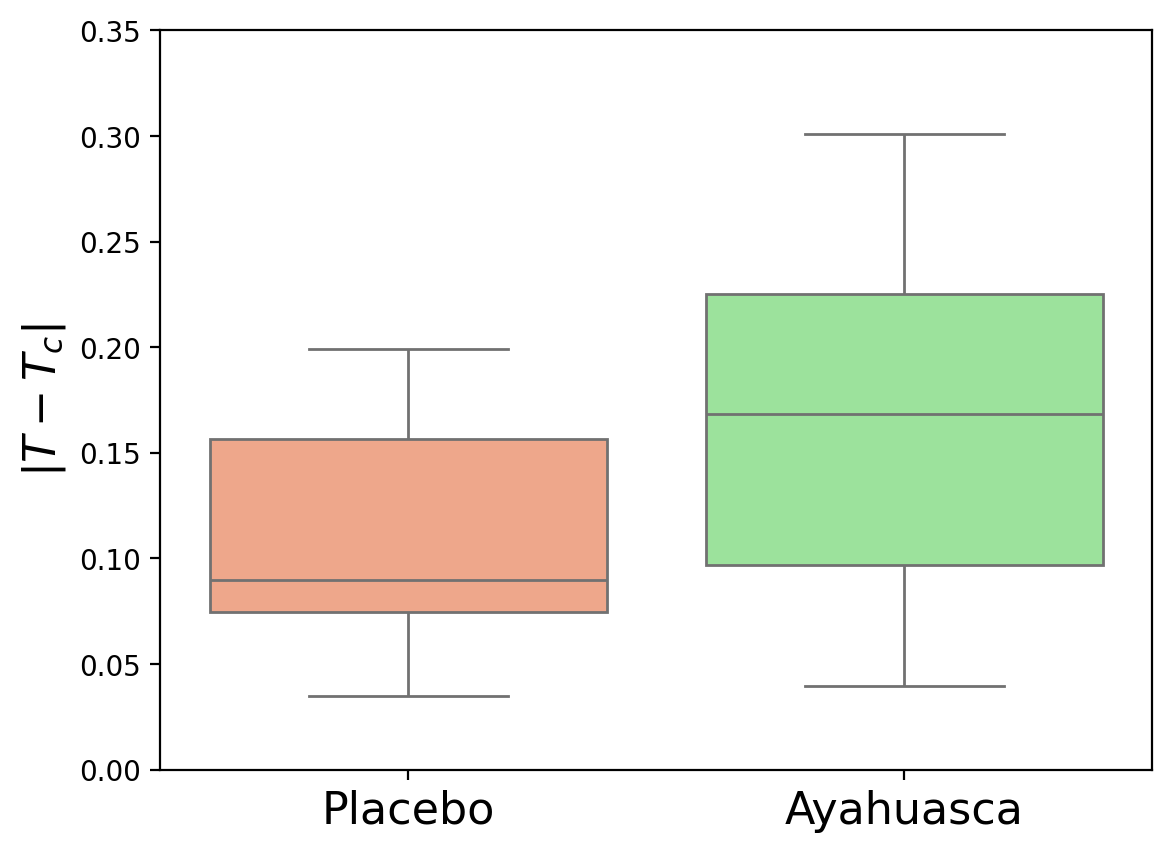

After TtestResult(statistic=2.6243207773849515, pvalue=0.012054018272210936, df=42.0)


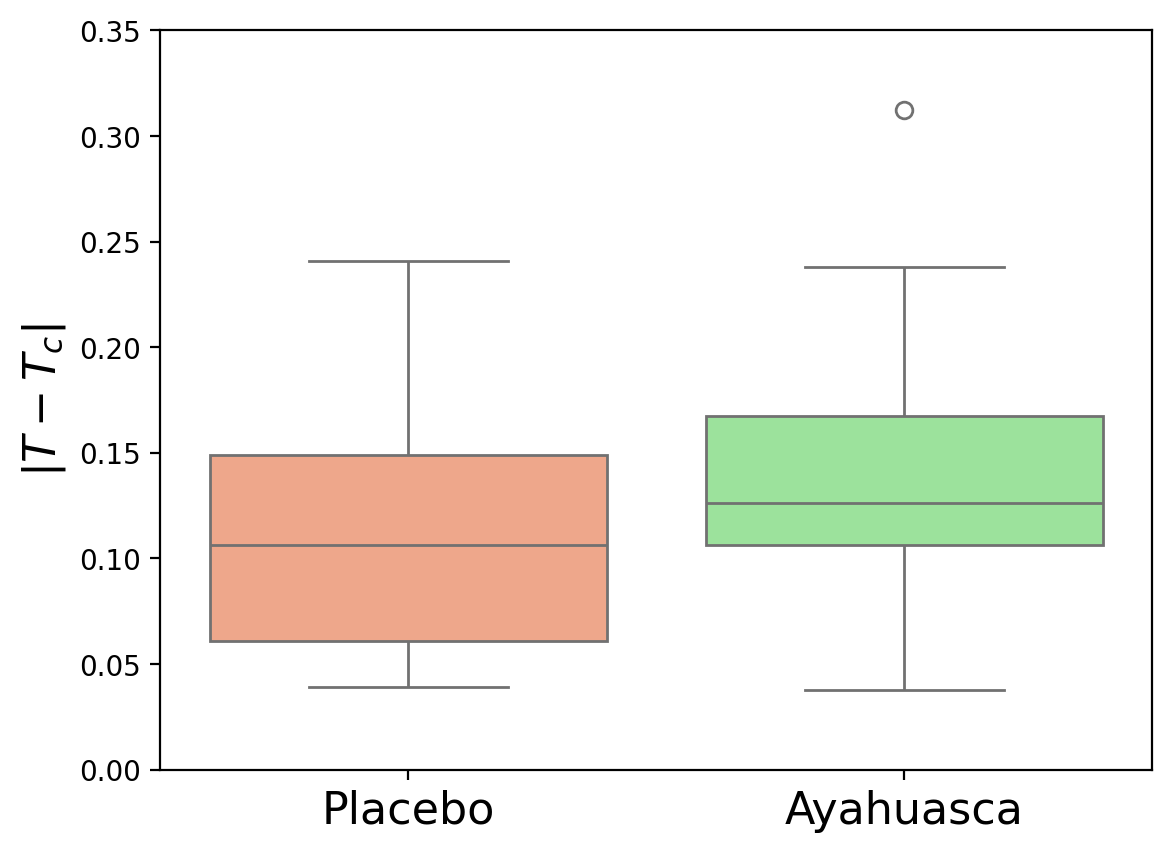

Before TtestResult(statistic=1.3622832075059361, pvalue=0.1803699505475681, df=42.0)


/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_13197/1002866019.py:161: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ayahuasca, x='Subject', y='Change', palette=colors)


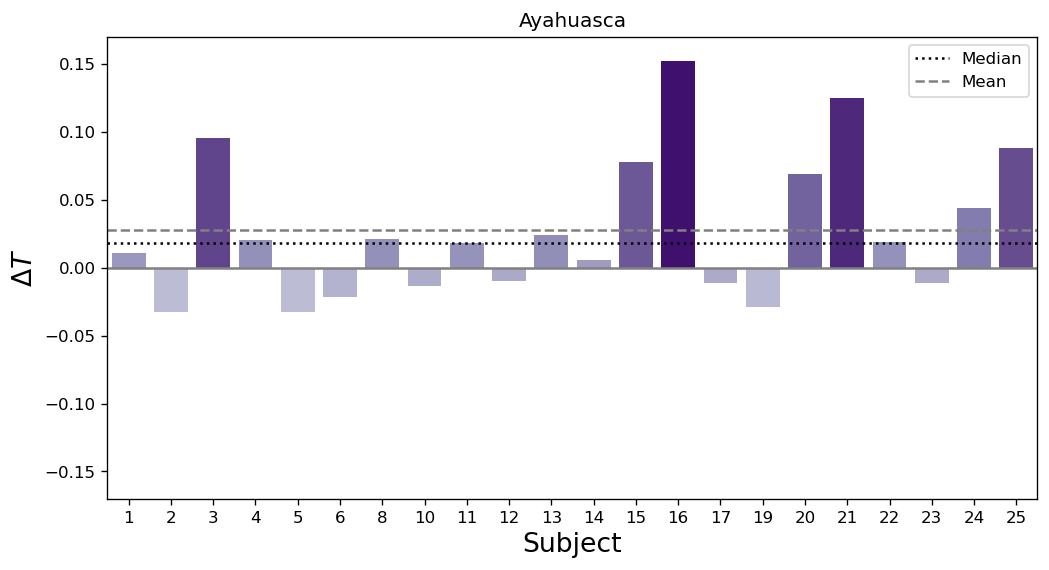

/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_13197/1002866019.py:181: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pd.DataFrame(placebo).reset_index(), x='Subject', y='Change', palette=colors)


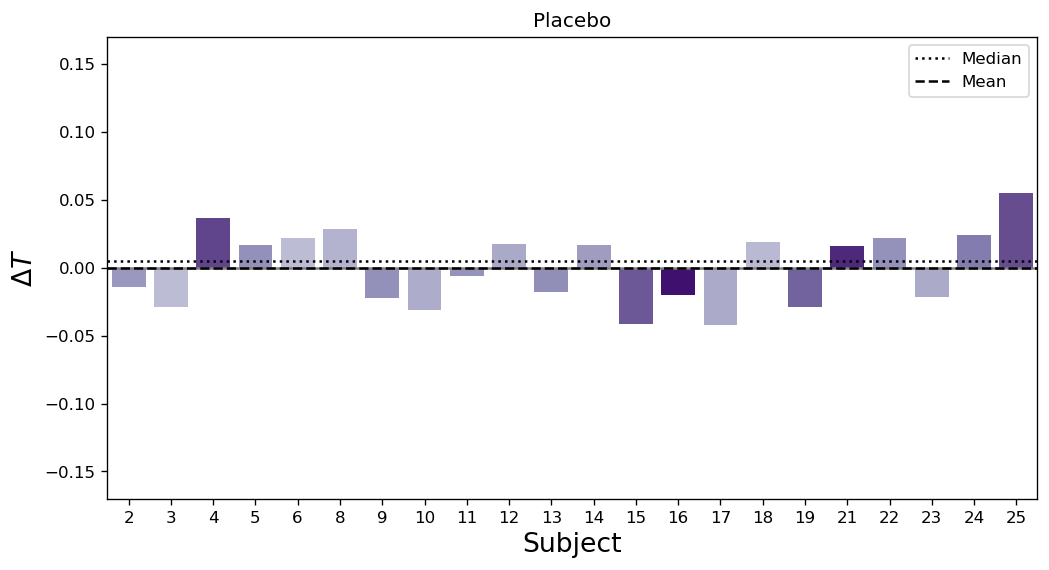

################ Group Placebo, Depedent Variable Change ##################
                            OLS Regression Results                            
Dep. Variable:                 Change   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.017
Date:                Fri, 30 Aug 2024   Prob (F-statistic):              0.501
Time:                        13:20:00   Log-Likelihood:                 6.2533
No. Observations:                  22   AIC:                             13.49
Df Residuals:                       9   BIC:                             27.68
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

In [15]:
import pandas as pd
import utils as ut
import numpy as np
from sgnn.model import GCN
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import pearsonr

df = pd.read_csv('/Users/rodrigo/Documents/data/Ayahuasca/data/subacute_pre_processed/corr_matrices_gordon.csv')#.drop(columns='Unnamed: 0')
HRS = pd.read_csv('/Users/rodrigo/Documents/data/Ayahuasca/data/ayahuasca_acute_preacute/Ayahuasca_HRS.csv')
HRS = HRS.replace({'J' : 'Ayahuasca', 'O' : 'Placebo'})

N = 333


condition = (
    ((df['Group'] == 'Ayahuasca') & (df['Subject'].isin([7, 9, 18]))) |     # Examinate subject 18
    ((df['Group'] == 'Placebo') & (df['Subject'].isin([1, 7])))
)

# Inverting the condition to keep rows that do NOT match the condition
df = df[~condition]

metrics = pd.DataFrame()

for g in ['Placebo', 'Ayahuasca']:
    for i in ['before', 'after']:
        aux = df[(df.Time == i) & (df.Group == g)]#.replace(np.nan, 0.0).reset_index().iloc[:,2:-3]
        X_fmri = aux.select_dtypes(include=float).iloc[:,:-6]
        #X_fmri = np.tanh(X_fmri)
        aux['STD'] = X_fmri.std(axis=1)
        aux['MEAN'] = X_fmri.mean(axis=1)

        #aux = aux.join(X_fmri.apply(lambda row: ut.calculate_properties(row=row, size=333), axis=1).apply(pd.Series))

        y = aux.reset_index().iloc[:,0]

        A = ut.reconstruct_symmetric_matrix(N, X_fmri.iloc[:,:].mean(axis=0))
        train_data, val_data = ut.create_graph(X_fmri, X_fmri, y, y,size=N, method={'knn_group' : ut.compute_KNN_graph(A, 15)})#, method={'threshold': 0.8})
        train_loader, val_loader = ut.create_batch(train_data, val_data, batch_size=1)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Load model
        model = GCN(N, 3).to(device)
        model.load_state_dict(torch.load('/Users/rodrigo/Documents/data/Ayahuasca/data/ayahuasca_acute_preacute/model_params_333_TRUE.pth'))
        model.eval()

        y_pred_aux_age = []
        for y_i in val_loader:
            y_pred_aux_age.append((model(y_i))[1].detach().numpy().ravel()[0])

        aux['TEMP'] = y_pred_aux_age
        metrics = pd.concat([metrics, aux.loc[:, ['Group', 'Subject', 'Time', 'MEAN', 'STD', 'TEMP','Translation_X', 'Translation_Y', 'Translation_Z', 
                        'Rotation_X', 'Rotation_Y', 'Rotation_Z']]])
        # metrics = pd.concat([metrics, aux.loc[:,['Group', 'Subject', 'Time', 'MEAN','STD','TEMP',
        #                                          'Weighted Clustering Coefficient', 'Weighted Eigenvector Centrality',
        #                                          'Weighted Density', 'Assortativity (Weight Correlation)'
        #                                          ]]])


        # my_dict_age = {}
        # for i in range(len(y.values)):
        #     my_dict_age[y.values[i]] = y_pred_aux_age[i]

# Inter-subject
# sns.boxplot(metrics, y='TEMP', x='Group', hue='Time')
# plt.show()

# Intra-subject
# Apply the function to each group using groupby
result = ut.calculate_diff(metrics, "TEMP")

result = pd.merge(result.reset_index(), HRS, how='left', on=['Group', 'Subject'])
#result = result.merge(pcr, how='inner', on=['Subject','Group'])


result['after'] = abs(result['after']  - 2.23)
result['before'] = abs(result['before']  - 2.23)

group_o = result[result.Group == 'Placebo']
group_j = result[result.Group == 'Ayahuasca']

from scipy import stats

colors = ['lightsalmon', 'lightgreen'] #['#808080', '#77dd77']

plt.figure(dpi=200)
# Display the resulting DataFrame
g = sns.boxplot(result, x='Group', y='Change',palette=colors)
#sns.swarmplot(result, x='Group', y='Change')
plt.ylabel(r'$ \Delta T$',  fontsize=16)
g.set_xticklabels(['Placebo', 'Ayahuasca'],  fontsize=16)
print('Change', stats.ttest_ind(group_o['Change'], group_j['Change']))

plt.show()

plt.figure(dpi=200)

ayahuasca = group_j[['Subject', 'after']]
placebo = group_o[['Subject', 'after']]
arr = [ayahuasca['after'], placebo['after']]
# Perform t-test
# Create a DataFrame for plotting
data_to_plot = pd.DataFrame({'Placebo': placebo['after'], 'Ayahuasca': ayahuasca['after']})
# Create the boxplot
g = sns.boxplot(data=data_to_plot,palette=colors)
# Set the x-tick labels
g.set_xticks(range(len(arr)))
g.set_xticklabels(['Placebo', 'Ayahuasca'],  fontsize=16)
# Set y-label and y-limits
plt.ylabel(r'$| T - T_c| $',  fontsize=16)
#plt.ylim(2.20, 2.55)
plt.ylim(0,.35)

# Show the plot
plt.show()
print('After', stats.ttest_ind(ayahuasca['after'], placebo['after']))

plt.figure(dpi=200)

ayahuasca = group_j[['Subject', 'before']]
placebo = group_o[['Subject', 'before']]
arr = [ayahuasca['before'], placebo['before']]
# Perform t-test
# Create a DataFrame for plotting
data_to_plot = pd.DataFrame({'Placebo': placebo['before'], 'Ayahuasca': ayahuasca['before']})
# Create the boxplot
g = sns.boxplot(data=data_to_plot,palette=colors)
# Set the x-tick labels
g.set_xticks(range(len(arr)))
g.set_xticklabels(['Placebo', 'Ayahuasca'],  fontsize=16)
# Set y-label and y-limits
plt.ylabel(r'$| T - T_c| $',  fontsize=16)
#plt.ylim(2.20, 2.55)
plt.ylim(0,.35)
# Show the plot
plt.show()
print('Before', stats.ttest_ind(ayahuasca['before'], placebo['before']))



ayahuasca = group_j[['Subject', 'Change', 'Affect_average']]
placebo = group_o[['Subject', 'Change', 'Affect_average']]

plt.figure(figsize=(10,5), dpi=120)
# Calculate the mean
mean_value = ayahuasca['Change'].mean()

# Normalize the values to create a gradient
#norm = plt.Normalize(ayahuasca['Change'].min(), ayahuasca['Change'].max())
norm = plt.Normalize(-.150, .150)
sm = plt.cm.ScalarMappable(cmap="Purples", norm=norm)
colors = [sm.to_rgba(val) for val in ayahuasca['Change']]

# Plotting
plt.title('Ayahuasca')
plt.axhline(y=0, color='grey', linestyle='-')
sns.barplot(data=ayahuasca, x='Subject', y='Change', palette=colors)
plt.ylabel(r'$\Delta T$', fontsize=16)
plt.xlabel('Subject', fontsize=16)
plt.axhline(y=ayahuasca['Change'].median(), color='black', linestyle='dotted', label='Median')
plt.axhline(y=mean_value, color='grey', linestyle='--', label='Mean')
plt.ylim(-.170,.170)
plt.legend()
plt.show()

plt.figure(figsize=(10,5), dpi=120)
plt.title('Placebo')
# Calculate the mean
mean_value = placebo['Change'].mean()

# Normalize the values to create a gradient
#norm = plt.Normalize(placebo['Change'].min(), placebo['Change'].max())
norm = plt.Normalize(-.150, .150)
sm = plt.cm.ScalarMappable(cmap="Purples", norm=norm)
colors = [sm.to_rgba(val) for val in ayahuasca['Change']]
plt.axhline(y=0, color='grey', linestyle='-')
sns.barplot(data=pd.DataFrame(placebo).reset_index(), x='Subject', y='Change', palette=colors)
plt.ylabel(r'$\Delta T$', fontsize=16)
plt.xlabel('Subject', fontsize=16)
plt.axhline(y=placebo['Change'].median(), color='black', linestyle='dotted', label='Median')
plt.axhline(y=mean_value, color='black', linestyle='--', label='Mean')
plt.ylim(-.170,.170)
plt.legend()
plt.show()

X = group_j[['Volition_average','Cognition_average', 'Perception_average','Somaesthesia_average',
             'Intensity_average','Affect_average', 'Volition_std', 'Cognition_std', 'Perception_std', 'Somaesthesia_std',
             'Intensity_std', 'Affect_std']]

for dep_variable in ['Change', 'after','before']:
    for group in ['Placebo', 'Ayahuasca']:

        print('################ Group {}, Depedent Variable {} ##################'.format(group, dep_variable))
        y = result[result.Group == group][dep_variable]
        X = result[result.Group == group][['Volition_average', 'Cognition_average', 'Perception_average', 'Somaesthesia_average',
                     'Intensity_average', 'Affect_average', 'Volition_std', 'Cognition_std', 'Perception_std',
                     'Somaesthesia_std',
                     'Intensity_std', 'Affect_std']]#,'PCR','cortiplasm' ,'bdnf' ,'cortisalivar']]
        #X = result[result.Group == group][['PCR','cortiplasm' ,'bdnf' ,'cortisalivar']]

        X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
        y = (y - y.min(axis=0)) / (y.max(axis=0) - y.min(axis=0))

        import statsmodels.api as sm

        X = sm.add_constant(X)
        mod = sm.OLS(y, X).fit()
        pred = mod.predict(X)

        print(mod.summary())



In [16]:
# Loop through each metric and community
for metric in all_metrics_df['Metric'].unique():
    # Extract data for each group
    aux = all_metrics_df[ 
                        (all_metrics_df['Metric'] == metric) & 
                        (all_metrics_df['Time'] == 'after')]['Value'].values
    print(aux.shape, result.after.shape)
    print(metric)
    print(stats.pearsonr(result.after, aux))

NameError: name 'all_metrics_df' is not defined

## Temperature vs Global Metrics

## Hallucinogen Rating Scale

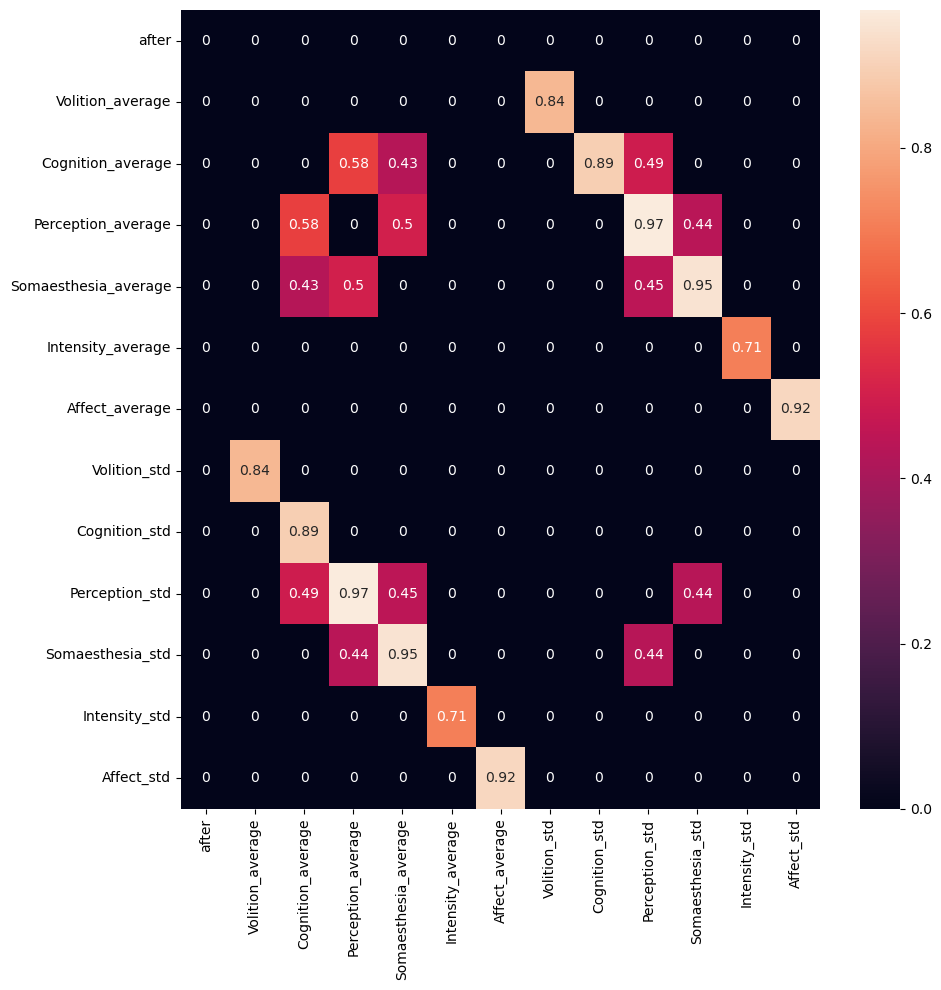

In [ ]:
# Calculating pairwise correlation and p-values
columns = ['after', 'Volition_average', 'Cognition_average', 'Perception_average', 'Somaesthesia_average',
                     'Intensity_average', 'Affect_average', 'Volition_std', 'Cognition_std', 'Perception_std',
                     'Somaesthesia_std',
                     'Intensity_std', 'Affect_std']

correlation_matrix = pd.DataFrame(np.zeros((len(columns), len(columns))), columns=columns, index=columns)
pvalue_matrix = pd.DataFrame(np.zeros((len(columns), len(columns))), columns=columns, index=columns)

for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            corr, pval = pearsonr(group_o[col1], group_o[col2])
            correlation_matrix.loc[col1, col2] = corr
            pvalue_matrix.loc[col1, col2] = pval

# Filter the correlation matrix for p-values lower than 0.05
significant_correlations = correlation_matrix[pvalue_matrix < 0.05]

# Replace NaN values with zeros for clarity
significant_correlations = significant_correlations.fillna(0)

plt.figure(figsize=(10,10))
sns.heatmap(significant_correlations, annot=True)
plt.tight_layout()

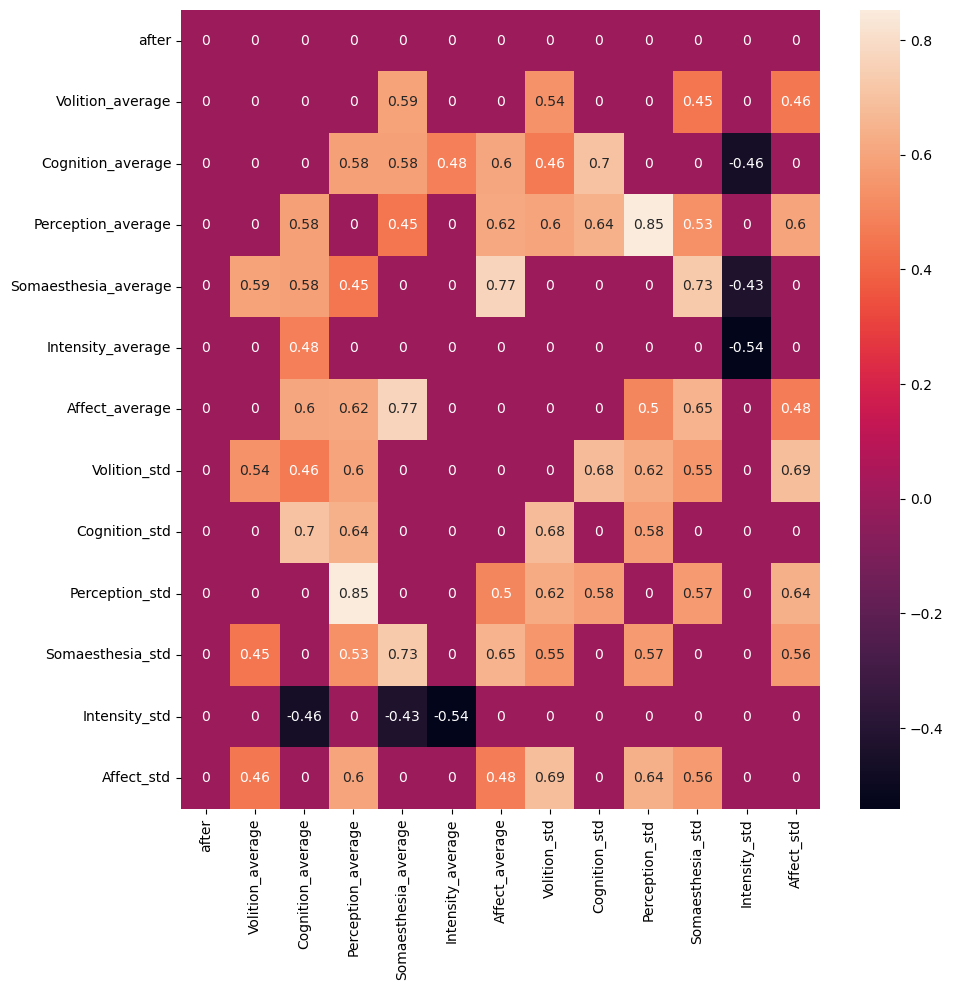

In [ ]:
# Calculating pairwise correlation and p-values
columns = ['after', 'Volition_average', 'Cognition_average', 'Perception_average', 'Somaesthesia_average',
                     'Intensity_average', 'Affect_average', 'Volition_std', 'Cognition_std', 'Perception_std',
                     'Somaesthesia_std',
                     'Intensity_std', 'Affect_std']#,'PCR','cortiplasm' ,'bdnf' ,'cortisalivar']

correlation_matrix = pd.DataFrame(np.zeros((len(columns), len(columns))), columns=columns, index=columns)
pvalue_matrix = pd.DataFrame(np.zeros((len(columns), len(columns))), columns=columns, index=columns)

for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            corr, pval = pearsonr(group_j[col1], group_j[col2])
            correlation_matrix.loc[col1, col2] = corr
            pvalue_matrix.loc[col1, col2] = pval

# Filter the correlation matrix for p-values lower than 0.05
significant_correlations = correlation_matrix[pvalue_matrix < 0.05]

# Replace NaN values with zeros for clarity
significant_correlations = significant_correlations.fillna(0)

plt.figure(figsize=(10,10))
sns.heatmap(significant_correlations, annot=True)
plt.tight_layout()

## Motion impact

In [ ]:
y = metrics['TEMP']
X = metrics[['Translation_X','Translation_Y', 'Translation_Z', 'Rotation_X', 'Rotation_Y', 'Rotation_Z']]

X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
y = (y - y.min(axis=0)) / (y.max(axis=0) - y.min(axis=0))

import statsmodels.api as sm

X = sm.add_constant(X)
mod = sm.OLS(y, X).fit()
pred = mod.predict(X)

print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                   TEMP   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                 -0.025
Method:                 Least Squares   F-statistic:                    0.6414
Date:                Fri, 30 Aug 2024   Prob (F-statistic):              0.697
Time:                        13:18:48   Log-Likelihood:                 5.8158
No. Observations:                  88   AIC:                             2.368
Df Residuals:                      81   BIC:                             19.71
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.4340      0.577      0.753

## Biochemical data

In [17]:
pcr = pd.read_csv('/Users/rodrigo/Documents/data/Ayahuasca/data/ayahuasca_acute_preacute/pcr_bdnf_cortisol_controles_aya_subacute.csv',  decimal=",")
# Creating the 'Subject' and 'Group' columns by separating the number and the letter in 'subjectid'
pcr['Subject'] = pcr['subjectid'].str.extract(r'(\d+)').astype(int)
pcr['Group'] = pcr['subjectid'].str.extract(r'([A-Za-z]+)')
pcr['Group'] = pcr['Group'].replace({'J' : 'Ayahuasca', 'O' : 'Placebo'})
pcr.rename(columns={'timepoint' : 'Time'}, inplace=True)
pcr.drop(columns=['subjectid'], inplace=True)


result = result.merge(pcr, how='inner', on=['Subject','Group'])

for dep_variable in ['Change', 'after','before']:
    for group in ['Placebo', 'Ayahuasca']:

        print('################ Group {}, Depedent Variable {} ##################'.format(group, dep_variable))
        y = result[result.Group == group][dep_variable]
        X = result[result.Group == group][['PCR','cortiplasm' ,'bdnf' ,'cortisalivar']]

        X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
        y = (y - y.min(axis=0)) / (y.max(axis=0) - y.min(axis=0))

        import statsmodels.api as sm

        X = sm.add_constant(X)
        mod = sm.OLS(y, X).fit()
        pred = mod.predict(X)

        print(mod.summary())

################ Group Placebo, Depedent Variable Change ##################
                            OLS Regression Results                            
Dep. Variable:                 Change   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                 -0.077
Method:                 Least Squares   F-statistic:                    0.3367
Date:                Fri, 30 Aug 2024   Prob (F-statistic):              0.851
Time:                        13:20:14   Log-Likelihood:                -5.7660
No. Observations:                  38   AIC:                             21.53
Df Residuals:                      33   BIC:                             29.72
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------